In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
import os
import ctypes
import numpy as np
from numpy.ctypeslib import ndpointer

def curve_length(X,opt=False,num_k=50,k_max=None):
    """
    Calculate curve length <Lk> for Higuchi Fractal Dimension (HFD)
    
    Input:
    
    X - input (time) series (must be 1D, to be converted into a NumPy array)
    opt (=True) - optimized? (if libhfd.so was compiled uses the faster code).
    num_k - number of k values to generate.
    k_max - the maximum k (the k array is generated uniformly in log space 
            from 2 to k_max)
    Output:
    k - interval "times", window sizes
    Lk - curve length
    """
    ### Make sure X is a NumPy array with the correct dimension
    X = np.array(X)
    if X.ndim != 1:
        raise ValueError("Input array must be 1D (time series).")
    N = X.size

    ### Get interval "time"
    k_arr = interval_t(N,num_val=num_k,kmax=k_max)

    ### The average length
    Lk = np.empty(k_arr.size,dtype=np.float)

    ### C library
    '''
    if opt:
        X = np.require(X, float, ('C', 'A'))
        k_arr = np.require(k_arr, ctypes.c_size_t, ('C', 'A'))
        Lk = np.require(Lk, float, ('C', 'A'))
        ## Load library here
        libhfd = init_lib()
        ## Run the C code here
        libhfd.curve_length(k_arr,k_arr.size,X,N,Lk)
    '''
    #else:
        ### Native Python run
    for i in range(k_arr.size):# over array of k's
            Lmk = 0.0
            for j in range(k_arr[i]):# over m's
                ## Construct X_k^m, i.e. X_(k_arr[i])^j, as X[j::k_arr[i]]
                ## Calculate L_m(k)
                Lmk += (
                    np.sum(
                        np.abs(
                            np.diff( X[j::k_arr[i]] )
                        )
                    )
                    * (N - 1) /
                    (
                        ( (N-j-1)//k_arr[i] )
                        *
                        k_arr[i]
                    )
                ) / k_arr[i]

            ### Calculate the average Lmk
            Lk[i] = Lmk / k_arr[i]

    return (k_arr, Lk);

def lin_fit_hfd(k,L,log=True):
    """
    Calculate Higuchi Fractal Dimension (HFD) by fitting a line to already computed
    interval times k and curve lengths L
    Input:
    k - interval "times", window sizes
    L - curve length
    log (=True) - k and L values will be transformed to np.log2(k) and np.log2(L),
                  respectively
    Output:
    HFD
    """
    if log:
        return (-np.polyfit(np.log2(k),np.log2(L),deg=1)[0]);
    else:
        return (-np.polyfit(k,L,deg=1)[0]);

def hfd(X,**kwargs):
    """
    Calculate Higuchi Fractal Dimension (HFD) for 1D data/series
    Input:
    X - input (time) series (must be 1D, to be converted into a NumPy array)
    Output:
    
    HFD
    """
    k, L = curve_length(X,**kwargs)
    return lin_fit_hfd(k, L);

# Generating th interval
def interval_t(size,num_val=50,kmax=None):
    list_space = []
    ### Generate sequence of interval times, k
    if kmax is None:
        k_stop = size//2
    else:
        k_stop = kmax
    if k_stop > size//2:   ## prohibit going larger than N/2
        k_stop = size//2
        print("Warning: k cannot be longer than N/2")
    for i in range(2, k_stop):
      list_space.append(i)    
    #k = np.logspace(start=np.log2(2),stop=np.log2(k_stop),base=2,num=num_val,dtype=np.int)
    return np.unique(list_space);

def init_lib():
    libdir = os.path.dirname(__file__)
    libfile = os.path.join(libdir, "libhfd.so")
    lib = ctypes.CDLL(libfile)

    rwptr = ndpointer(float, flags=('C','A','W'))
    rwptr_sizet = ndpointer(ctypes.c_size_t, flags=('C','A','W'))

    lib.curve_length.restype = ctypes.c_int
    lib.curve_length.argtypes = [rwptr_sizet, ctypes.c_size_t, rwptr, ctypes.c_size_t, rwptr]

    return lib;

In [ ]:
# Validation of the algorithm
x = np.random.randn(1000)
y = np.empty(990)
for i in range(x.size-10):
	y[i] = np.sum(x[:(i+10)])
	
## Note x is a Guassian noise, y is the original Brownian data used in Higuchi, Physica D, 1988.

print(hfd(x)) # ~ 2.00
print(hfd(y)) # ~ 1.50
#print(a, b)

1.996176292950832
1.3477833727909883


In [ ]:
k1, l1 = curve_length((x))
k2, l2 = curve_length((y))
#print(k, l)

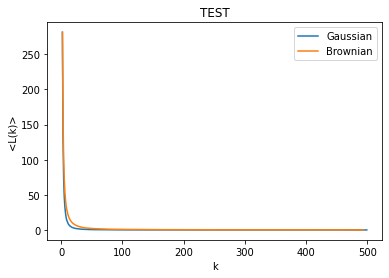

In [ ]:
import math
x1 = k1 #k_interval_times
y1 = l1 #curve_length_list
x2 = k2
y2 = l2
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
#log_y = []
#for i in curve_length_list:
#  log_y.append(math.log10(i))
#y = log_y
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("TEST") 
plt.xlabel("k") 
plt.ylabel("<L(k)>")
plt.plot(x1,y1,label='Gaussian')
plt.plot(x2,y2, label='Brownian')
plt.legend() 
plt.show()

# **Data PreProcessing**

In [ ]:
data = pd.read_csv('/content/data/Data AND Reports - DATA_HFD.csv')
data.head()

,MH,KA,AP,TN,KL,DL,UP,WB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12.000000,5.0,2.000000,3.0,12.000000,7.000000,4.000000,2.000000
2,15.000000,6.0,1.333333,3.0,18.333333,3.333333,2.666667,1.666667
3,14.000000,7.2,1.400000,4.6,15.600000,3.000000,2.800000,1.400000
4,14.857143,7.0,1.428571,5.0,19.428571,2.857143,3.571429,1.857143


In [ ]:
mh_in=data.MH
print(mh_in[1::])

ka_in=data.KA
print(ka_in[1::])

ap_in=data.AP
print(ap_in[1::])

tn_in=data.TN
print(tn_in[1::])

kl_in=data.KL
print(kl_in[1::])

dl_in=data.DL
print(dl_in[1::])

up_in=data.UP
print(up_in[1::])

wb_in=data.WB
print(wb_in[1::])

1        12.000000
2        15.000000
3        14.000000
4        14.857143
5        17.428571
          ...     
276    3596.857143
277    3516.428571
278    3372.800000
279    3641.333333
280    3431.000000
Name: MH, Length: 280, dtype: float64
1         5.000000
2         6.000000
3         7.200000
4         7.000000
5         8.714286
          ...     
276    1083.142857
277    1052.142857
278    1003.800000
279    1035.333333
280    1005.000000
Name: KA, Length: 280, dtype: float64
1        2.000000
2        1.333333
3        1.400000
4        1.428571
5        2.000000
          ...    
276    389.571429
277    374.857143
278    341.400000
279    363.666667
280    355.000000
Name: AP, Length: 280, dtype: float64
1         3.000000
2         3.000000
3         4.600000
4         5.000000
5         5.142857
          ...     
276    1085.571429
277    1070.285714
278    1050.200000
279    1042.666667
280    1027.000000
Name: TN, Length: 280, dtype: float64
1        12.000000
2   

In [ ]:
import pandas

In [ ]:
#converting a data frame into a numbpy array "np.array"
import numpy
#aa_np = list(numpy.concatenate().flat))

mh=mh_in.to_numpy()
print(mh[1::])

ka=ka_in.to_numpy()
print(ka[1::])

ap=ap_in.to_numpy()
print(ap[1::])

tn=tn_in.to_numpy()
print(tn[1::])

kl=kl_in.to_numpy()
print(kl[1::])

dl=dl_in.to_numpy()
print(dl[1::])

up=up_in.to_numpy()
print(up[1::])

wb=wb_in.to_numpy()
print(wb[1::])

[1.20000000e+01 1.50000000e+01 1.40000000e+01 1.48571429e+01
 1.74285714e+01 1.84285714e+01 1.75714286e+01 2.78571429e+01
 3.04285714e+01 4.25714286e+01 4.72857143e+01 6.41428571e+01
 7.77142857e+01 9.25714286e+01 1.02285714e+02 1.14285714e+02
 1.34428571e+02 1.55285714e+02 1.60857143e+02 1.76428571e+02
 2.09428571e+02 2.37428571e+02 2.54428571e+02 2.62428571e+02
 2.49571429e+02 2.69571429e+02 3.16857143e+02 3.33142857e+02
 3.62571429e+02 3.90428571e+02 4.60857143e+02 4.99428571e+02
 5.68571429e+02 5.52571429e+02 5.60571429e+02 5.85714286e+02
 6.09428571e+02 5.81571429e+02 6.69857143e+02 6.66857143e+02
 7.00857143e+02 8.50142857e+02 8.86714286e+02 9.77571429e+02
 1.06800000e+03 1.07957143e+03 1.13314286e+03 1.31385714e+03
 1.26571429e+03 1.27171429e+03 1.30914286e+03 1.36428571e+03
 1.43385714e+03 1.49685714e+03 1.55457143e+03 1.66528571e+03
 1.81557143e+03 1.91071429e+03 2.01685714e+03 2.21171429e+03
 2.35485714e+03 2.45400000e+03 2.51557143e+03 2.51742857e+03
 2.52157143e+03 2.557714

# Maharashtra

In [ ]:
#Inputs to higuchi algorithm 
mh1= mh[1:174:]
mh2= mh[178:268:]
print(mh1.shape)
print(mh2.shape)
n1=int(280/2)
n2=int(280/2)
k_interval_times1, curve_length_list1 = curve_length(mh1, n1-1, n1)
k_interval_times2, curve_length_list2 = curve_length(mh2, n2-1, n2)
print(k_interval_times1, curve_length_list1)
print(k_interval_times2, curve_length_list2)

(173,)
(90,)
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85] [11693.60883132  7600.22961938  5566.44451753  4347.48549103
  3530.74437338  2984.33585055  2572.72261122  2257.77799796
  2004.05646445  1799.3234918   1630.01258085  1486.74614413
  1365.80206493  1259.23544636  1170.37258967  1091.39687328
  1020.90633103   963.42461421   907.47841713   859.30959548
   819.8501728    776.33571238   741.75063483   712.56581976
   679.39091295   649.80590745   626.57396573   608.41291217
   585.63433654   564.34359086   544.57062206   527.40239549
   513.66326368   500.63796199   485.35154569   470.03244205
   455.68561815   442.26144761   429.6146957    418.71398587
   409.67460062   402.68482322   393.63639719   384.00772358
   374.71428573   366.43744598   358.85449565   351.4063001

In [ ]:
hfd(mh1)

1.0815188243929645

In [ ]:
hfd(mh2)

1.1285586080561414

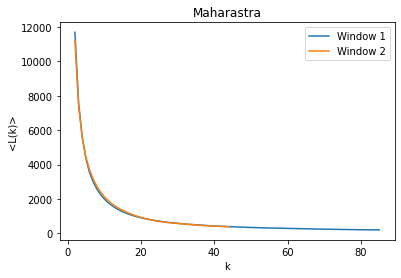

In [ ]:
#The Graphs

x1 = k_interval_times1
y1 = curve_length_list1
x2 = k_interval_times2
y2 = curve_length_list2
plt.title("Maharastra") 
plt.xlabel("k") 
plt.ylabel("<L(k)>") 
plt.plot(x1,y1,label='Window 1') 
plt.plot(x2,y2,label='Window 2') 
plt.legend()
plt.show()

1.2576473516316704


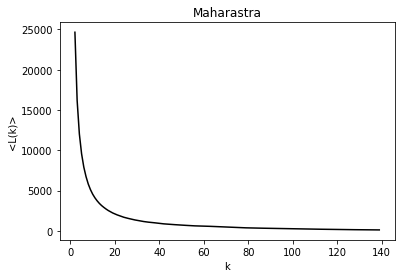

[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139] [24644.40740912 16181.10528293 12030.89963237  9573.21573848
  7919.98342253  6742.26292892  5824.704113    5124.89858498
  4560.53685387  4112.82690919  3737.52244406  3419.55061346
  3153.07571832  2927.88225465  2722.39101722  2538.63208167
  2382.54080248  2233.59787261  2107.90596089  1995.21311608
  1893.14032236  1796.63649119  1702.08178913  1625.40739271
  1558.20650364  1492.26915361  1422.70581958  1367.57102331
  1314.92151

In [ ]:
a= mh[1:281:]
n=int(280/2)
k_interval_times, curve_length_list = curve_length(a, n-1, n)
b=hfd(a)
print(b)
x = k_interval_times
y = curve_length_list
plt.title("Maharastra") 
plt.xlabel("k") 
plt.ylabel("<L(k)>") 
plt.plot(x,y, color='k') 
plt.show()
print(k_interval_times, curve_length_list)

#Karnataka

In [ ]:
#Inputs to higuchi algorithm 
ka1= ka[1:96:]
ka2= ka[96:204:]
ka3= ka[204:281:]
print(ka1.shape)
print(ka2.shape)
print(ka3.shape)
n1=int(280/2)
n2=int(280/2)
k_interval_times1, curve_length_list1 = curve_length(ka1, n1-1, n1)
k_interval_times2, curve_length_list2 = curve_length(ka2, n2-1, n2)
k_interval_times3, curve_length_list3 = curve_length(ka3, n2-1, n2)
print(k_interval_times1, curve_length_list1)
print(k_interval_times2, curve_length_list2)
print(k_interval_times3, curve_length_list3)

(95,)
(108,)
(77,)
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46] [320.68478258 203.1182932  145.47143563 111.50846984  89.83980726
  74.17867769  61.2475903   51.08145884  43.84704603  38.00741885
  32.24433579  27.95059187  24.53307997  22.00747231  20.42028041
  19.25336803  18.30303694  17.83832712  17.61811786  17.00017122
  16.29805418  15.6368487   15.11915578  14.80139398  14.38694378
  13.78927283  13.05849863  12.43723537  11.89400071  11.46174316
  11.09668492  10.72462206  10.37646187  10.06925181   9.83636525
   9.68027334   9.56284027   9.4160729    9.18111429   8.86839839
   8.53881909   8.25029458   7.98366595   7.76990037   7.58058419]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53] [6927.56502688 4494.56613763 3305.98583449 2580.33891985 2088.38573776
 1717.22320273 14

In [ ]:
hfd(ka1)

1.1944316895961669

In [ ]:
hfd(ka2)

1.151049470469037

In [ ]:
hfd(ka3)

1.1710453553119928

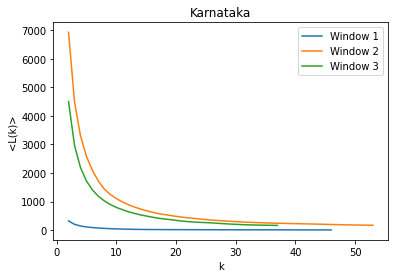

In [ ]:
#The Graphs

x1 = k_interval_times1
y1 = curve_length_list1
x2 = k_interval_times2
y2 = curve_length_list2
x3 = k_interval_times3
y3 = curve_length_list3
plt.title("Karnataka") 
plt.xlabel("k") 
plt.ylabel("<L(k)>") 
plt.plot(x1,y1,label='Window 1') 
plt.plot(x2,y2,label='Window 2') 
plt.plot(x3,y3,label='Window 3') 
plt.legend()
plt.show()

1.1370000495673447


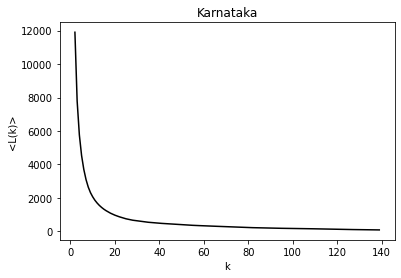

[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139] [11904.57826332  7793.19444472  5761.14120742  4528.94636905
  3699.58694232  3092.69221172  2643.66710721  2310.75929856
  2060.92969846  1855.6241489   1688.3680443   1547.22968799
  1427.57976393  1323.33634901  1234.29808392  1155.01089858
  1082.45934256  1021.35139981   962.81354259   914.04920849
   866.00137122   824.03686494   783.21517998   746.41680574
   716.86429141   688.30136014   662.07499263   644.06693909
   624.29691

In [ ]:
a= ka[1:281:]
n=int(280/2)
k_interval_times, curve_length_list = curve_length(a, n-1, n)
b=hfd(a)
print(b)
x = k_interval_times
y = curve_length_list
plt.title("Karnataka") 
plt.xlabel("k") 
plt.ylabel("<L(k)>") 
plt.plot(x,y, color='k') 
plt.show()
print(k_interval_times, curve_length_list)

#Andhra Pradesh

In [ ]:
#Inputs to higuchi algorithm 
ap1= ap[1:140:]
ap2= ap[175:281:]
print(ap1.shape)
print(ap2.shape)
n1=int(280/2)
n2=int(280/2)
k_interval_times1, curve_length_list1 = curve_length(ap1, n1-1, n1)
k_interval_times2, curve_length_list2 = curve_length(ap2, n2-1, n2)
print(k_interval_times1, curve_length_list1)
print(k_interval_times2, curve_length_list2)

(139,)
(106,)
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68] [4941.29947511 3281.4736744  2467.39863205 1981.33705755 1658.97365321
 1424.29699468 1245.83584683 1106.74216885  994.48175935  901.55979914
  823.11350259  754.01791795  694.08857624  642.52426267  594.84584837
  555.0198314   513.54056298  478.76621689  446.53574524  412.53672596
  387.78447641  366.24246287  337.04265791  314.79181367  298.7740305
  285.69320603  271.37614145  250.58341231  233.78949947  221.80405588
  213.23223834  206.67485719  200.97156197  193.27423862  180.10228011
  168.6317941   158.67168493  150.12227079  143.32730997  138.63914765
  135.65300505  133.66930291  132.24277676  131.03416793  129.69263435
  124.59904673  118.03515599  112.03187302  106.50783749  101.41306328
   96.64840428   92.28133944   88.29598856   84.76679944   81.62294584
 

In [ ]:
hfd(ap1)

1.3125343300672765

In [ ]:
hfd(ap2)

1.0154582774507206

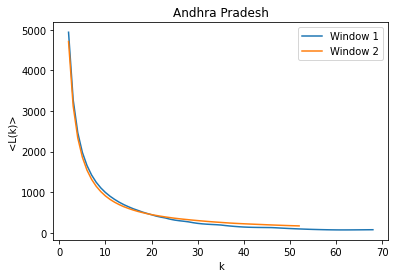

In [ ]:
#The Graphs

x1 = k_interval_times1
y1 = curve_length_list1
x2 = k_interval_times2
y2 = curve_length_list2
plt.title("Andhra Pradesh") 
plt.xlabel("k") 
plt.ylabel("<L(k)>") 
plt.plot(x1,y1,label='Window 1') 
plt.plot(x2,y2,label='Window 2') 
plt.legend()
plt.show()

1.131938837451091


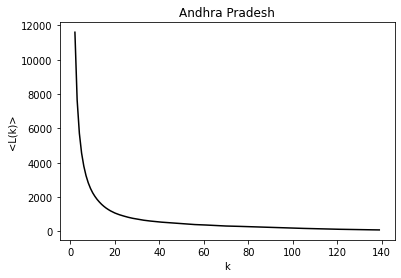

[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139] [11603.54692081  7657.27022122  5715.58649143  4563.58430309
  3802.23949852  3246.52741485  2828.93306527  2504.06516156
  2245.51511421  2037.70594114  1860.05031555  1709.71471953
  1575.62343435  1461.24941404  1360.05038809  1273.60492937
  1195.13076092  1127.9697162   1067.13836211  1016.50688621
   969.37048701   926.7425347    890.82378671   854.57642607
   819.47583849   789.67799523   760.56001667   737.49299246
   712.37186

In [ ]:
a= ap[1:281:]
n=int(280/2)
k_interval_times, curve_length_list = curve_length(a, n-1, n)
b=hfd(a)
print(b)
x = k_interval_times
y = curve_length_list
plt.title("Andhra Pradesh") 
plt.xlabel("k") 
plt.ylabel("<L(k)>") 
plt.plot(x,y, color='k') 
plt.show()
print(k_interval_times, curve_length_list)

#Tamil Nadu

In [ ]:
#Inputs to higuchi algorithm 
tn1= tn[1:129]
tn2= tn[134:205:]
tn3= tn[205:281:]
print(tn1.shape)
print(tn2.shape)
print(tn3.shape)
n1=int(280/2)
n2=int(280/2)
k_interval_times1, curve_length_list1 = curve_length(tn1, n1-1, n1)
k_interval_times2, curve_length_list2 = curve_length(tn2, n2-1, n2)
k_interval_times3, curve_length_list3 = curve_length(tn2, n2-1, n2)
print(k_interval_times1, curve_length_list1)
print(k_interval_times2, curve_length_list2)
print(k_interval_times3, curve_length_list3)

(128,)
(71,)
(76,)
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63] [3782.74971661 2473.80186758 1812.76588428 1415.30570745 1149.34816013
  960.5756613   817.39666295  705.57910278  618.75331881  553.78218213
  502.94914149  461.00116392  424.15725898  392.16185048  367.28326091
  341.60121529  321.71785282  303.41607481  286.54790773  273.90795738
  262.31424372  250.35735208  239.99842323  231.85457892  225.49792858
  218.44657209  210.75536386  203.41150177  196.5816313   190.6380106
  185.890979    180.81472219  176.11502476  171.30098525  166.08953026
  160.66936955  155.43856707  150.52665419  146.00060796  142.05822131
  138.88526764  135.60840429  131.41567631  127.58094971  124.10136654
  120.93911175  118.16733295  115.72124625  113.55932148  111.56568072
  109.61764144  107.59424635  105.48639716  103.25157522  101.03993681
   98.96562

In [ ]:
hfd(tn1)

1.0760353537255416

In [ ]:
hfd(tn2)

1.4043072611248546

In [ ]:
hfd(tn3)

1.120326192450034

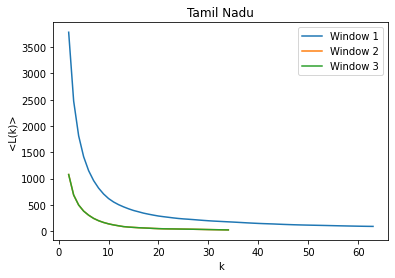

In [ ]:
#The Graphs

x1 = k_interval_times1
y1 = curve_length_list1
x2 = k_interval_times2
y2 = curve_length_list2
x3 = k_interval_times3
y3 = curve_length_list3
plt.title("Tamil Nadu") 
plt.xlabel("k") 
plt.ylabel("<L(k)>") 
plt.plot(x1,y1,label='Window 1') 
plt.plot(x2,y2,label='Window 2')
plt.plot(x3,y3,label='Window 3')
plt.legend()
plt.show()

1.111560327530472


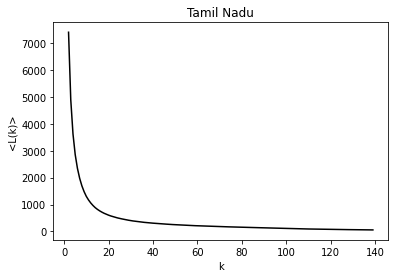

[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139] [7399.17510314 4890.73295351 3622.21401376 2853.52059416 2345.63511032
 1975.59892347 1695.71154964 1478.46888492 1303.37541582 1169.12611771
 1057.49123483  964.67238254  885.25785472  820.80919944  765.681444
  718.04489147  675.54372561  639.72063676  605.97141841  576.34188461
  551.41859492  526.26905095  504.08026442  483.3809664   466.7049748
  449.29081339  431.97932979  417.55023918  403.5341937   390.45337075
  379.72221283  

In [ ]:
a= tn[1:281:]
n=int(280/2)
k_interval_times, curve_length_list = curve_length(a, n-1, n)
b=hfd(a)
print(b)
x = k_interval_times
y = curve_length_list
plt.title("Tamil Nadu") 
plt.xlabel("k") 
plt.ylabel("<L(k)>") 
plt.plot(x,y, color='k') 
plt.show()
print(k_interval_times, curve_length_list)

#Kerala

In [ ]:
#Inputs to higuchi algorithm 
kl1= kl[1:205:]
kl2= kl[206:281:]
print(kl1.shape)
print(kl2.shape)
n=int(280/2)
k_interval_times1, curve_length_list1 = curve_length(kl1, n-1, n)
k_interval_times2, curve_length_list2 = curve_length(kl2, n-1, n)
print(k_interval_times1, curve_length_list1)
print(k_interval_times2, curve_length_list2)

(204,)
(75,)
[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101] [5144.79620519 3246.48454047 2376.74454162 1847.26865019 1513.95812749
 1287.45153405 1110.39425387  975.39081048  869.87915646  785.33104975
  715.75869743  656.48983144  604.64001992  558.77306856  518.03445182
  483.42287561  450.52807031  420.28685134  394.90084611  369.31818128
  348.78294533  328.76670541  309.83241266  295.48533287  279.54924843
  263.80804175  252.62386202  242.96584942  229.76587819  218.07821751
  209.54569939  203.15207755  197.20494843  187.22424124  178.13789316
  170.27456899  164.21266207  159.80152132  155.83698583  151.53428853
  144.492078

In [ ]:
hfd(kl1)

1.2455508571786043

In [ ]:
hfd(kl2)

1.2499323196081578

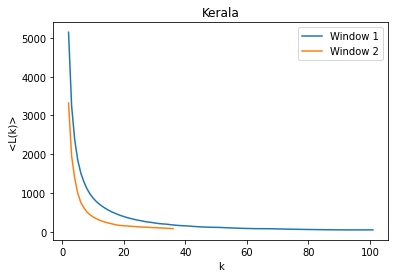

In [ ]:
#The Graphs

x1 = k_interval_times1
y1 = curve_length_list1
x2 = k_interval_times2
y2 = curve_length_list2
plt.title("Kerala") 
plt.xlabel("k") 
plt.ylabel("<L(k)>") 
plt.plot(x1,y1,label='Window 1') 
plt.plot(x2,y2,label='Window 2') 
plt.legend()
plt.show()

1.1096244784619382


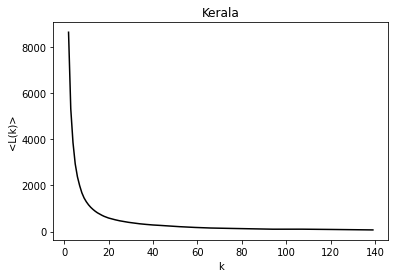

[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139] [8634.5792658  5316.62066983 3855.62319478 2932.5956198  2372.07202392
 1988.46670949 1676.1326747  1452.60594554 1289.02005398 1156.66735185
 1047.14548447  957.39664201  878.83832891  811.02684605  755.05091691
  704.08241838  657.74102469  619.13189943  584.92677034  558.23842844
  531.43579875  508.02653937  484.94658697  464.66259117  447.18776969
  429.20985753  410.97988815  397.73373481  384.52689634  368.78818195
  355.3289571

In [ ]:
a= kl[1:281:]
n=int(280/2)
k_interval_times, curve_length_list = curve_length(a, n-1, n)
b=hfd(a)
print(b)
x = k_interval_times
y = curve_length_list
plt.title("Kerala") 
plt.xlabel("k") 
plt.ylabel("<L(k)>") 
plt.plot(x,y, color='k') 
plt.show()
print(k_interval_times, curve_length_list)

#Delhi

In [ ]:
#Inputs to higuchi algorithm 
dl1= dl[1:96:]
dl2= dl[96:134:]
dl3= dl[134:179:]
dl4= dl[179:237:]
print(dl1.shape)
print(dl2.shape)
print(dl3.shape)
print(dl4.shape)
n2=int(280/2)
k_interval_times1, curve_length_list1 = curve_length(dl1, n2-1, n2)
k_interval_times2, curve_length_list2 = curve_length(dl2, n2-1, n2)
k_interval_times3, curve_length_list3 = curve_length(dl3, n2-1, n2)
k_interval_times4, curve_length_list4 = curve_length(dl4, n2-1, n2)
print(k_interval_times1, curve_length_list1)
print(k_interval_times2, curve_length_list2)
print(k_interval_times3, curve_length_list3)
print(k_interval_times4, curve_length_list4)

(95,)
(38,)
(45,)
(58,)
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46] [1822.36154225 1199.15324569  884.04678973  689.34328042  561.62582304
  471.17852604  403.40188378  349.83444596  307.30452646  273.46097124
  247.25660588  222.75007044  203.67960803  186.14166255  173.21753395
  158.34380312  147.77768306  140.84761766  130.38485416  122.01957003
  115.61512781  111.22406235  107.276602    101.28356165   95.57445127
   90.4227014    86.2133956    82.70640875   80.03820929   78.19407374
   75.63051641   71.56181386   68.00002302   64.94130223   62.39304494
   60.09064569   57.9743021    55.95155089   54.01534449   52.42967276
   51.15724801   50.08928474   49.28688542   48.74395819   48.50375185]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] [1223.45932546  812.70823292  601.50006184  474.53229931  390.67056876
  330.60370677  287.80129277  254.61880265  227.82573807  206.1097635
  18

In [ ]:
hfd(dl1)

1.2002487024506796

In [ ]:
hfd(dl2)

1.0420678189719943

In [ ]:
hfd(dl3)

1.0768556794243753

In [ ]:
hfd(dl4)

1.1814590154612137

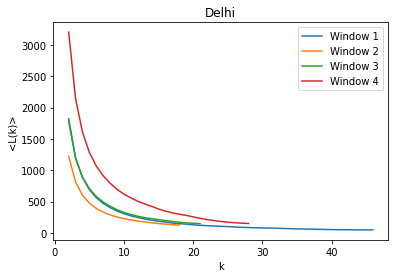

In [ ]:
#The Graphs

x1 = k_interval_times1
y1 = curve_length_list1
x2 = k_interval_times2
y2 = curve_length_list2
x3 = k_interval_times3
y3 = curve_length_list3
x4 = k_interval_times4
y4 = curve_length_list4
plt.title("Delhi") 
plt.xlabel("k") 
plt.ylabel("<L(k)>") 
plt.plot(x1,y1,label='Window 1') 
plt.plot(x2,y2,label='Window 2')
plt.plot(x3,y3,label='Window 3')
plt.plot(x4,y4,label='Window 4')
plt.legend()
plt.show()

1.5364305715775382


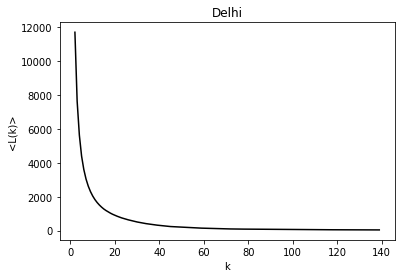

[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139] [11718.68101197  7646.96035165  5635.68567533  4398.80086445
  3607.94805035  3042.78829969  2624.9750656   2301.07729175
  2040.75174919  1829.14682825  1654.71972948  1507.62632624
  1381.46307623  1271.36750258  1179.8336958   1101.41126891
  1024.55739612   957.73755799   898.60830987   844.52755065
   792.95157165   747.32098351   706.47882197   665.76048074
   631.41883054   598.5262907    563.24475305   529.70949862
   504.06676

In [ ]:
a= dl[1:281:]
n=int(280/2)
k_interval_times, curve_length_list = curve_length(a, n-1, n)
b=hfd(a)
print(b)
x = k_interval_times
y = curve_length_list
plt.title("Delhi") 
plt.xlabel("k") 
plt.ylabel("<L(k)>") 
plt.plot(x,y, color='k') 
plt.show()
print(k_interval_times, curve_length_list)

#Uttar Pradesh

In [ ]:
#Inputs to higuchi algorithm 
up1= up[1:174:]
up2= up[174:280:]
print(up1.shape)
print(up2.shape)
n1=int(280/2)
n2=int(280/2)
k_interval_times1, curve_length_list1 = curve_length(up1, n1-1, n1)
k_interval_times2, curve_length_list2 = curve_length(up2, n2-1, n2)
print(k_interval_times1, curve_length_list1)
print(k_interval_times2, curve_length_list2)

(173,)
(106,)
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85] [3510.99607843 2307.68191025 1708.47056415 1348.1347211  1105.25727304
  934.10437762  806.42844301  711.43377374  637.56467969  578.10294437
  529.07361426  487.97991667  453.0287315   422.63865371  396.30004309
  372.5574492   351.86546621  333.0804232   316.26407491  300.64646535
  286.6940503   273.76170203  261.88428898  251.38831563  241.26594129
  232.41052169  224.2628893   217.23992682  210.34707845  203.87563371
  197.99631097  192.34316731  186.85047696  182.09124931  177.74032901
  173.11289285  168.55702067  164.28992846  160.24718497  156.44961664
  152.78257233  149.44986822  146.41896652  143.3595099   140.3258336
  137.37373365  134.47936824  131.43255265  128.28777148  125.25065384
  122.39904596  119.

In [ ]:
hfd(up1)

1.03863108576431

In [ ]:
hfd(up2)

1.2628605340538936

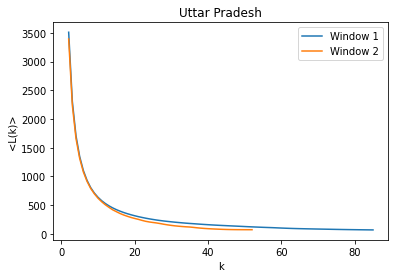

In [ ]:
#The Graphs

x1 = k_interval_times1
y1 = curve_length_list1
x2 = k_interval_times2
y2 = curve_length_list2
plt.title("Uttar Pradesh") 
plt.xlabel("k") 
plt.ylabel("<L(k)>") 
plt.plot(x1,y1,label='Window 1') 
plt.plot(x2,y2,label='Window 2') 
plt.legend()
plt.show()

1.188173807170832


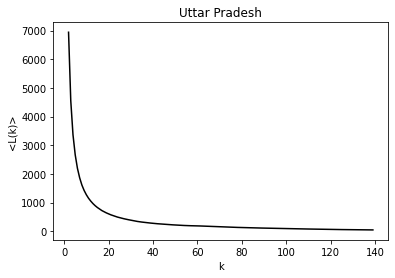

[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139] [6942.0485615  4552.68581828 3366.09336193 2665.56841569 2195.05227175
 1863.97369689 1612.29026895 1423.4773467  1273.61679371 1150.11339223
 1049.62406286  962.6012861   888.5833096   825.47326156  770.16788874
  719.52016553  678.96060756  639.23032019  604.18165385  572.65767647
  545.09070938  519.15641522  493.03128101  472.06759805  452.64666428
  433.15068986  415.19403807  399.78232966  384.5384817   368.64950944
  353.7122831

In [ ]:
a= up[1:281:]
n=int(280/2)
k_interval_times, curve_length_list = curve_length(a, n-1, n)
b=hfd(a)
print(b)
x = k_interval_times
y = curve_length_list
plt.title("Uttar Pradesh") 
plt.xlabel("k") 
plt.ylabel("<L(k)>") 
plt.plot(x,y, color='k') 
plt.show()
print(k_interval_times, curve_length_list)

#West Bengal

In [ ]:
#Inputs to higuchi algorithm
wb1= wb[1:70:] 
wb2= wb[70:218:]
wb3= wb[218:280:]
print(wb1.shape)
print(wb2.shape)
print(wb3.shape)
n1=int(280/2)
n2=int(280/2)
k_interval_times1, curve_length_list1 = curve_length(wb1, n1-1, n1)
k_interval_times2, curve_length_list2 = curve_length(wb2, n2-1, n2)
k_interval_times3, curve_length_list3 = curve_length(wb3, n2-1, n2)
print(k_interval_times1, curve_length_list1)
print(k_interval_times2, curve_length_list2)
print(k_interval_times3, curve_length_list3)

(69,)
(148,)
(62,)
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33] [157.21269832  94.33868844  65.21041666  48.43562783  38.57599006
  31.74342943  26.93204852  23.14676521  20.51840635  17.89021263
  16.25066578  14.55509808  13.5039428   12.36582998  11.52120768
  10.9998572   10.56269406  10.01951046   9.54429921   9.11709764
   8.74466149   8.61109246   8.59856702   8.4806595    8.27630318
   7.98333684   7.65224212   7.34108546   6.9715351    6.63290511
   6.34113479   6.11133823]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73] [2215.64383655 1461.86805562 1084.17057305  858.68772427  709.18943743
  604.07711375  524.02969902  461.42302814  411.75196156  371.79100447
  337.57976906  309.05774818  285.56386054  264.55125926  246.47022502
  231.6370344   217.42444

In [ ]:
hfd(wb1)

1.121139589321594

In [ ]:
hfd(wb2)

1.015165157270153

In [ ]:
hfd(wb3)

1.0977320347276127

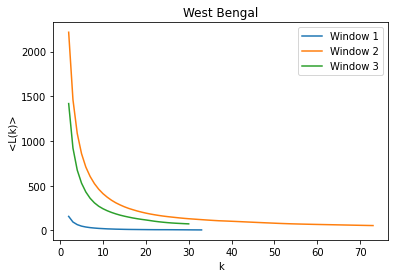

In [ ]:
#The Graphs

x1 = k_interval_times1
y1 = curve_length_list1
x2 = k_interval_times2
y2 = curve_length_list2
x3 = k_interval_times3
y3 = curve_length_list3
plt.title("West Bengal") 
plt.xlabel("k") 
plt.ylabel("<L(k)>") 
plt.plot(x1,y1,label='Window 1') 
plt.plot(x2,y2,label='Window 2') 
plt.plot(x3,y3,label='Window 3') 
plt.legend()
plt.show()

1.0654088520100284


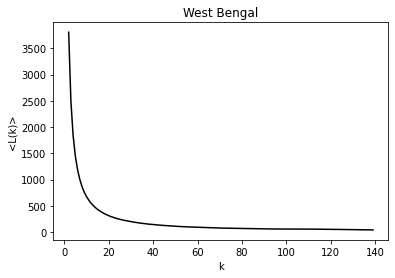

[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139] [3806.83743693 2496.87287808 1837.98109491 1446.82530087 1187.91704049
 1003.51210076  865.30021993  759.31407405  676.95054285  609.62995266
  553.19512398  506.0299123   465.61698961  430.55276911  400.58098539
  374.31600854  350.34759868  329.67278354  311.11198022  293.80512998
  279.04543966  265.3437783   252.83229588  241.91589393  231.62117952
  221.87119457  213.52694449  204.90368915  196.71308743  189.8854913
  183.02397966

In [ ]:
a= wb[1:281:]
n=int(280/2)
k_interval_times, curve_length_list = curve_length(a, n-1, n)
b=hfd(a)
print(b)
x = k_interval_times
y = curve_length_list
plt.title("West Bengal") 
plt.xlabel("k") 
plt.ylabel("<L(k)>") 
plt.plot(x,y, color='k') 
plt.show()
print(k_interval_times, curve_length_list)